# Predicting Sovereign Debt Crises

> **Author**
- Raphaël Grach (#49059165)

**Objective**

Use an artificial neural network (ANN) analysis to build a model trying to predict sovereign debt crises using joint data from the International Monetary fund (IMF) and the World Bank. The methodology will be following closely [Fioramanti (2008)](#nn-fioramanti2008) and build on the work of [Manasse, Roubini and Schimmelpfennig (2003)](#nn-MRS2003) (MRS 2003).

### Outline

- [Background: probit and logit](#Background:-Probit-and-logit)
- [Early Warning Systems (EWS)](#Early-Warning-Systems-%28EWS%29)
- [Data](#Data)
    - [World Bank data](#World-Bank-data)
    - [Exploring the data](#Exploring-the-data)
- [The Model](#The-Model)
    - [In-sample estimation](#In-sample-estimation-model-%28IS%29-%28Train:-1980-2004-/-Test:-2002-2004%29)
    - [Out-of-sample estimation 1](#Out-of-sample-estimation-model-1-%28OS1%29-%28Train:-1981-2001-/-Test:-2002-2004%29)
    - [Out-of-sample estimation 2](#Out-of-sample-estimation-model-2-%28OS2%29-%28Train:-1991-2001-/-Test:-2002-2004%29)
- [Performance](#Performance)
    - [Mean squared errors (MSE)](#Mean-squared-errors-%28MSE%29)
    - [Hit rate](#Hit-rate)
- [Conclusion](#Conclusion)
- [References](#References)

## Background: probit and logit

The previous episodes of sovereign debt crises has led international organisations to develop mechanisms aiming at predicting their occurence. The traditional parametric identification strategy used in the literature is the random effect probit (REP) estimator. Probit and logit estimations method (though more information can be retrieved [here](http://www.columbia.edu/~so33/SusDev/Lecture_9.pdf)) are basiacally mostly trying to estimate effect of independent variables on the *probability* of a certain event happening. They usually do that by transforming a discontinuous dependent variable $Y$ (that is in general a dummy) into a smoother function using transformations.

The process is usually conducted by first tranform the original $Y$ (that takes values $\{0,1\}$) into a **probability** (that is distributed over the interval $[0,1]$) and then into a desired function.

- The **probit** method usually uses the odd-ratio: $\frac{p}{(1-p)}$ where p is the probability of event $Y$ happening. It is defined on $[0,+\infty)$
- The **logit** method uses the log-transform of the odd-ratio: $\ln(\frac{p}{(1-p)})$ that is defined on $(-\infty,+\infty)$

The "random effects" hypothesis is an alternative to the "fixed-effects" hypothesis that is usually used in econometrics. The random effects assumption stipulates that the unobserved heterogeneity is continuous and **uncorrelated with the independent variables**.

## Early Warning Systems (EWS)

In the past two decades, researchers have tried to develop models able to recognize signals annoucing a potential crisis, the so-called Early Warning Systems (EWS). These models sought to predict the likelihood of a financial crisis using both parametric and non-paramteric estimation methods. A more extensive discussion of methodologies is proposed in [Ciarlone and Trebeschi (2005)](#nn-ciarlone2005). 

A number of emerging countries have known what is referred as a "sovereign debt crisis" indicating that the level of sovereign debt reaches levels that the country alone cannot sustain. Facing such crises required the help of international organizations such as the IMF to adjust their situation. The objective of this project will be to identify early signs of a sovereign debt crisis and use them as a predictor.

This study will be using an artificial neural network (ANN) and compare its performance with the REP estimators.

**Disclaimer**: Since some of the referenced papers had access to greater resources that this current research, this study has room for improvement. Fioramanti's ANN *beats* the REP in terms of predictive power, it is not given that this one will.

## Data

The data is composed of different macro-economic indicators for a variety of developing countries as outlined in [Fioramanti (2008)](#nn-fioramanti2008). The definition of a sovereign debt crisis will be the one in [MRS (2003)](#nn-MRS2003):

> "A country is defined to be in a debt crisis if it is classified as being in default by Standard & Poor’s or if it receives a large nonconcessional IMF loan defined as access in excess of 100% of quota." (p.8)

The panel data is collected from the World Bank and the IMF databases. Let's first have a look at the episodes of sovereign debt crisis for each of these countries.

In [20]:
# copy and paste this to import all the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
from matplotlib import cm
%matplotlib inline
import math
#!pip install qeds
import qeds # QuantEcon collab
qeds.themes.mpl_style();
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, pipeline, neural_network, metrics # Neural network package
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm 

In [21]:
crisis_episodes = pd.read_excel("Crisis_episodes.xlsx",index_col="Countries")
countries_0 = ['China', 'Colombia', 'Cyprus', 'Egypt', 'Israel', 'Morocco', 'Oman'] # Countries with 0 years in crisis

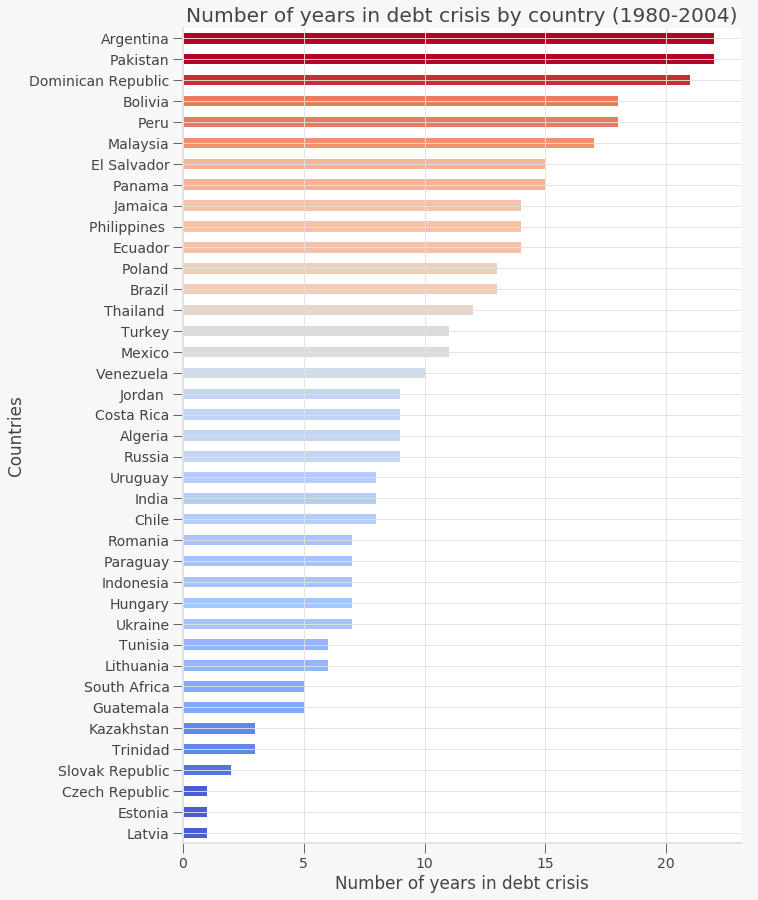

In [22]:
colors = cm.coolwarm(crisis_episodes.drop(countries_0
                                         ).sort_values(by="Number of years in crisis")["Number of years in crisis"]/22,
                    bytes = False)

fig = crisis_episodes.drop(countries_0
                    ).sort_values(by="Number of years in crisis"
                                 ).plot(y = "Number of years in crisis", 
                                        kind = "barh", 
                                        figsize = (10,15),
                                        color=colors,
                                       legend = False)
fig.set_title('Number of years in debt crisis by country (1980-2004)')
fig.set_xlabel('Number of years in debt crisis')
fig.set_facecolor('w')

With some countries like Argentina spending  **22 years** in a debt crisis, a model that could help better anticipate those episodes can definitely benefit both the country and international organisations.

### World Bank data

[Table of indicators of the World Bank.](http://wdi.worldbank.org/tables) A handy feature of the World Bank data is that it uses different sources, notably the IMF to compute its own indicators. That is, data originally coming from the IMF can be accessed via the World Bank API.

In [23]:
!pip install world_bank_data
import world_bank_data as wb

countries = ["Algeria", "Argentina", "Bolivia",
"Brazil", "Chile", "China", "Colombia", "Costa Rica", "Cyprus", "Czech Republic", "Dominican Republic", "Ecuador",
"Egypt, Arab Rep.", "El Salvador", "Estonia", "Guatemala", "Hungary", "India", "Indonesia", "Israel", "Jamaica",
"Jordan", "Kazakhstan", "Latvia", "Lithuania", "Malaysia", "Mexico", "Morocco", "Oman", "Pakistan", "Panama",
"Paraguay", "Peru", "Philippines",  "Poland", "Romania", "Russian Federation", "Slovak Republic", "South Africa",
"Thailand", "Trinidad and Tobago", "Tunisia", "Turkey", "Ukraine", "Uruguay", "Venezuela, RB"]

# 3-letter ISO code of each country
iso = ["DZA",
"ARG", "BOL", "BRA", "CHL", "CHN", "COL", "CRI", "CYP", "CZE", "DOM", "ECU", "EGY", "SLV", "EST", "GTM",
"HUN", "IND", "IDN", "ISR", "JAM", "JOR", "KAZ", "LVA", "LTU", "MYS", "MEX", "MAR", "OMN", "PAK", "PAN",
"PRY", "PER", "PHL", "POL", "ROU", "RUS", "SVK", "ZAF", "THA", "TTO", "TUN", "TUR", "UKR", "URY", "VEN"]

dates = list(range(1980,2005)) # Dates range from 1980 to 2004


In [24]:
#wb.get_topics() # Displays the complete list of World Bank data topics (For consultative use)

In [25]:
#wb.get_sources() # Displays the full list of sources (For consultative use)

### [Here is an extensive list of World Bank indicators](https://data.worldbank.org/indicator?tab=all)

The indicator can be found in the link of the resource when accessed. For example:

Exports of goods and services: `https://data.worldbank.org/indicator/NE.EXP.GNFS.CD?view=chart`

The indicator code is represented by the series of **UPPERCASE CHARACTERS**.

In [26]:
#wb.get_indicators() # Displays the full list of indicators (For consultative use)

In [27]:
# List of indicators we'll use
ind_use = [
    #GNI Growth rate
    "NY.GNP.MKTP.KD.ZG", 
    #GDP Growth Rate
    "NY.GDP.MKTP.KD.ZG",
    # Broad money growth (% annual)
    "FM.LBL.BMNY.ZG",
    # Inflation (consumer prices)
    "FP.CPI.TOTL.ZG",
    # Real interest rate
    "FR.INR.RINR",
    # Deposit interest rate
    "FR.INR.DPST",
    # Taxes on international trade (% of revenue) (proxy for openness, higher = less open)
    "GC.TAX.INTT.RV.ZS",
    # Net trade in goods and services (BoP, in USD) (Proxy for trade balance)
    "BN.GSR.GNFS.CD",
    # Present value of external debt (% of GNI and % of exports)
    "DT.DOD.PVLX.GN.ZS", "DT.DOD.PVLX.EX.ZS",
    # Total external debt (Current USD and % of GNI)
    "DT.DOD.DECT.CD", "DT.DOD.DECT.GN.ZS",
    # Short-term debt as % of total reserves
    "DT.DOD.DSTC.IR.ZS",
    # Short-term external debt stocks (Current USD)
    "DT.DOD.DSTC.CD",
    # Exports of goods and services (% of GDP and current USD)
    "NE.EXP.GNFS.ZS", "NE.EXP.GNFS.CD",
    # Total reserves (Current USD including gold) (and as % total external debt)
    "FI.RES.TOTL.CD", "FI.RES.TOTL.DT.ZS",
    # Total debt service (% of exports)
    "DT.TDS.DECT.EX.ZS",
    # Public debt service (% of GNI and % of exports)
    "DT.TDS.DPPG.GN.ZS", "DT.TDS.DPPG.XP.ZS",
    # Current account (% of GDP and in Current USD)
    "BN.CAB.XOKA.GD.ZS", "BN.CAB.XOKA.CD",
    # Portfolio equity, net inflows (Current USD)
    "BX.PEF.TOTL.CD.WD",
    # Foreign Direct Investment (net inflow in current USD and % of GDP)
    "BX.KLT.DINV.CD.WD", "BX.KLT.DINV.WD.GD.ZS"]

In [28]:
master_countries = pd.read_excel("master_countries.xls")
master_countries["year"] = master_countries["year"].astype(str) # Set the correct type for "year"

In [29]:
type(master_countries.loc[0][0]) # should be "str"

str

In [30]:
# Query data through pandas_datareader (This might take some time)
import warnings
warnings.filterwarnings('ignore')

import pandas_datareader
from pandas_datareader import wb
wb_data = pandas_datareader.wb.WorldBankReader(symbols = ind_use, countries = iso, start = 1980, end = 2004).read()

In [31]:
# Create the lacking variables

# Total external debt as % of reserves
wb_data["ted_res"] = (wb_data["DT.DOD.DECT.CD"] / wb_data["FI.RES.TOTL.CD"])*100
# Short-term external debt as % of reserves
wb_data["sted_res"] = (wb_data["DT.DOD.DSTC.CD"] / wb_data["FI.RES.TOTL.CD"])*100
# Short-term external debt as % of exports
wb_data["sted_xgs"] = (wb_data["DT.DOD.DSTC.CD"] / wb_data["NE.EXP.GNFS.CD"])*100
# Short-term external debt as % of total external debt
wb_data["sted_ted"] = (wb_data["DT.DOD.DSTC.CD"] / wb_data["DT.DOD.DECT.CD"])*100
# Current account as % of reserves
wb_data["cac_res"] = (wb_data["BN.CAB.XOKA.CD"] / wb_data["FI.RES.TOTL.CD"])*100
# Current account as % of portfolio equity, net inflows
wb_data["cac_pef"] = (wb_data["BN.CAB.XOKA.CD"] / wb_data["BX.PEF.TOTL.CD.WD"])*100 # This produced 'inf' values
# Current account as % of FDI
wb_data["cac_fdi"] = (wb_data["BN.CAB.XOKA.CD"] / wb_data["BX.KLT.DINV.CD.WD"])*100
# Total external debt as % of exports 
wb_data["ted_xgs"] = (wb_data["DT.DOD.DECT.CD"] / wb_data["NE.EXP.GNFS.CD"])*100

In [32]:
# Merge the two data sets
master = pd.merge(wb_data.reset_index(), master_countries.drop("iso",axis=1), on = ["country","year"], how="left")
master = master.set_index(["country","year"])
master.head()

NY.GNP.MKTP.KD.ZG  NY.GDP.MKTP.KD.ZG  FM.LBL.BMNY.ZG  \
country   year                                                         
Argentina 2004           1.069367           9.029573       21.427310   
          2003          10.201217           8.837041       29.634853   
          2002         -13.204427         -10.894485       19.708854   
          2001          -4.613779          -4.408840      -19.436218   
          2000          -0.831529          -0.788999        1.531034   

                FP.CPI.TOTL.ZG  FR.INR.RINR  FR.INR.DPST  GC.TAX.INTT.RV.ZS  \
country   year                                                                
Argentina 2004             NaN    -9.789158     2.614968          15.799545   
          2003             NaN     7.828852    10.160701          16.470869   
          2002             NaN    16.179804    39.248446          13.638532   
          2001             NaN    29.120285    16.163597           4.284476   
          2000             NaN     9.945072     8.337878           4.893369   

                BN.GSR.GNFS.CD  DT.DOD.PVLX.GN.ZS  DT.DOD.PVLX.EX.ZS   ...    \
country   year                                                         ...     
Argentina 2004    1.193361e+10                NaN                NaN   ...     
          2003    1.561150e+10                NaN                NaN   ...     
          2002    1.571728e+10                NaN                NaN   ...     
          2001    3.521811e+09                NaN                NaN   ...     
          2000   -1.831883e+09                NaN                NaN   ...     

                BX.KLT.DINV.WD.GD.ZS      ted_res    sted_res   sted_xgs  \
country   year                                                             
Argentina 2004              2.505018   854.542849  135.042097  67.610786   
          2003              1.294811  1154.477701  158.125464  67.663914   
          2002              2.198958  1413.593093  141.385413  53.484395   
          2001              0.806164  1048.740175  137.431550  64.295618   
          2000              3.665791   596.621456  112.616044  90.717397   

                 sted_ted    cac_res       cac_pef     cac_fdi     ted_xgs  \
country   year                                                               
Argentina 2004  15.802847  16.337013  -3728.136970   77.867050  427.839281   
          2003  13.696710  57.496409  12455.899005  492.728858  494.015815   
          2002  10.001847  83.551802  -7565.248533  407.956127  534.745201   
          2001  13.104442 -25.972378 -12145.175563 -174.523751  490.639871   
          2000  18.875627 -35.705216    278.280224  -86.200297  480.605996   

                crisis  
country   year          
Argentina 2004     1.0  
          2003     1.0  
          2002     1.0  
          2001     1.0  
          2000     1.0  

[5 rows x 35 columns]

## Exploring the data

Before digging into the neural network model, we could have a look at how the data behaves.

Variables that are known to have a significant effect on the likelihood of debt crisis is the total external debt as % of reserves and GDP growth. Let's see how GDP growth looks on total external debt.

In [33]:
def plot_country(x = "NY.GDP.MKTP.KD.ZG", y = "DT.DOD.DECT.GN.ZS", country = "Argentina"):
    
    """
    When called, returns the scatter plot of the desired indicators for the desired coutry.
    By default, it plots GDP growth against total external debt as % of GNI for Argentina.
    --
    Arguments:
    x: str. Indicator on the x axis, needs to be a World Bank indicator. Default: GDP growth
    y: str. Indicator in the y axis, needs to be a World Bank indicator Default: Total external debt as % of GNI
    country: str. Needs to be a country in the list 'countries'. Default: 'Argentina'
    """
    fig,ax = plt.subplots()

    df = wb_data.reset_index().groupby("country").get_group(country)
    df = df.replace([np.inf,-np.inf], np.nan)
    df = df.fillna(value=0) # Replace NaN values by 0 (avoids errors)
    df.plot(x, y, ax=ax, kind = "scatter")
    
    # Add linear regression line
    lr = LinearRegression()
    X = df[x].values.reshape(-1,1) # Note the uppercase X here (for linear fitting)
    y = df[y].values.reshape(-1,1)
    lr.fit(X,y)
    
    # If the graph is a flat line, it is likely that the data is not available
    
    _x = np.linspace(-10, 10,100).reshape(-1,1) # Note the lowercase _x here (for plotting)
    y_pred = lr.predict(_x)
    ax.plot(_x, y_pred, color="red",linestyle="--")
    
    
    ax.set_title(f"Plot for {country}")
    
    
    return fig,ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1d1b5eb8>)

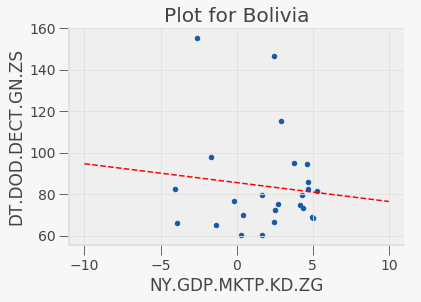

In [34]:
plot_country(country="Bolivia")

We could also have a look at which countries experience the highest debts by comparing them all.

In [35]:
wb1 = wb_data.reset_index()
reduced = wb1[wb1["country"].isin(["Argentina","Bolivia","Costa Rica","Indonesia","Jamaica","Jordan"])]
colors = qeds.themes.COLOR_CYCLE
cmap = dict(zip(reduced["country"].unique(), colors))
nom_color = (0.8,0.8,0.8)
wb1 = wb1.replace([np.inf,-np.inf], np.nan)
wb1 = wb1.fillna(value=0) 
wb1 = wb1.sort_values(by="year")
wb1.index = wb1["year"]
gwb1 = wb1.groupby(["country"])


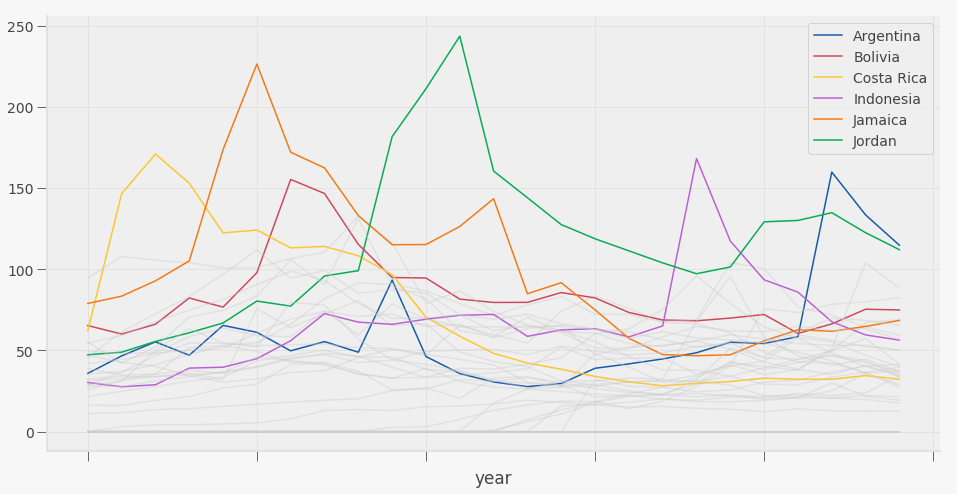

In [36]:
fig1, ax1 = plt.subplots(figsize = (16,8))
for count,df in gwb1:
    if df["DT.DOD.DECT.GN.ZS"].max() >= 155:
        df.plot(x="year",y="DT.DOD.DECT.GN.ZS", ax=ax1,legend=True, alpha = 1.0, label = count, color = cmap[count])
    else:
        df.plot(x="year",y="DT.DOD.DECT.GN.ZS", ax=ax1, legend=False, alpha = 0.4, color = nom_color)

We can note that four countries had an external debt superior to 155% of their GNI: Argentina, Bolivia, Indonesia, Jamaica and Jordan.

## The Model
### Network construction
We will be using a multi-layer perceptron (MLP) ANN to conduct the prediction. Following [Fioramanti (2008)](#nn-fioramanti2008), the ANN in this study will be a two-layer neural network of the form:

$$
Y = F \big(  F  (X \omega_1 + b_1)\omega_2 + b_2 \big)  \omega_3 + b_3
$$

Where the activation function $F(\cdot)$ is the **sigmoid** function (also called logistic function): $F(x) = \frac{1}{1+e^{-x}}$ which is smooth and differentiable. 

The $\omega_i$ are a series of *weight matrices*, $\omega_1$ multiplies the feature matrix $X$. Each layer is adjusted of a *bias matrix* $b_i$.

This neural network has three units in the hidden layer and one unit in the output layer. The author tried additional models with more hidden units but there was not significant performance improvement. This rather simple architecture has, however, a pretty strong approximation power according to the [Universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) stipulating that neural nets with a single layer and a finite number of neurons can approximate a wide range of continuous functions on $\mathbb{R}^n$.

The network uses three different training sets (identical to the REP referenced in Fioramanti's paper): 

- It first uses the whole sample to train and uses 2002-2004 to test its prediction (in-sample forecast).
- In a second time, the training set uses the years 1981-2001 to train and the rest to assess the performance (out-of-sample forecast).
- The third try uses the same approach, but the training years are 1990-2001.

Number of observations: 1150

Number of independent variables: 35

Count of $crisis = 1$: 421

Measure of performance: mean-squared errors (MSE)

The reference paper uses the [Levenberg–Marquardt](http://people.duke.edu/~hpgavin/ce281/lm.pdf) (LM) algorithm to minimise the MSE of its ANN model. Since the `sklearn` package does not allow for such an algorithm, the solver will be the [LBFGS](http://aria42.com/blog/2014/12/understanding-lbfgs) (for Limited-Memory Broyden–Fletcher–Goldfarb–Shanno) algorithm which is deemed appropriate for smaller datasets. The LBFGS algorithm is designed to optimise smooth function without constraints. We thus set the regularization parameter $\alpha = 0$.

### In-sample estimation model (IS) (Train: 1980-2004 / Test: 2002-2004)

In [37]:
def nn_in_sample():
    
    """
    When called, this function returns the artificial neural network model
    using the in-sample training method.
    It takes the whole sample as training (1980-2004) and the years 2002-2004 as testing.
    """
    # Flag missing values with an indicator (=1 if value is missing)
    indic = master.drop("crisis",axis=1).isnull().replace(to_replace = [True, False], value = [1, 0])
    for col in list(indic.columns):
        indic = indic.rename(columns={f"{col}":f"missing_{col}" })
    
    _master = pd.merge(master, indic, left_index=True, right_index=True, how="left")
    
    # Some variables spat out "inf" values, let's replace them by NaN
    df = _master.replace([np.inf, -np.inf], np.nan).copy()
    # Replace NaN values by 0 (drops them from the model)
    df = df.fillna(value=0)
    
   
    
    # Training data
    train_data = df # Takes the whole dataset as training
    X_train = train_data.drop("crisis", axis=1)
    y_train = train_data["crisis"]
    
    # Testing data
    testing_dates = ["2002","2003","2004"] # Tests for dates 2002-2004
    test_data = df.loc[pd.IndexSlice[:, testing_dates], :]
    X_test = test_data.drop("crisis", axis=1)
    y_test = test_data["crisis"]
    
    #Parameters of the model
    nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(), # this will do the input scaling
        neural_network.MLPRegressor((100, 100),
                                   activation = "logistic",
                                   solver = "lbfgs",
                                   alpha = 0, # LBFGS is designed to work better without penalty
                                   max_iter = 10_000, # Keep = 100 to save computing time, can get up to 10000
                                   learning_rate = "adaptive")
    )
    
    return (nn_scaled_model, X_train, y_train, X_test, y_test)

In [38]:
# Now on to compute the MSE
def mse_in_sample():
    """
   When called, this function returns the train and test MSE of the in-sample training method.
    """
    nn_scaled_model, X_train, y_train, X_test, y_test = nn_in_sample() # Import the values from the in-sample model
    nn_scaled_model.fit(X_train,y_train)
    
    #MSE on test and training
    mse_train = metrics.mean_squared_error(y_train, nn_scaled_model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, nn_scaled_model.predict(X_test))
    
    return [mse_train , mse_test] # Return as a list to be displayed later

### Out-of-sample estimation model 1 (OS1) (Train: 1981-2001 / Test: 2002-2004)

In [39]:
def nn_out_sample_1():
    
    """
    When called, this function returns the artificial neural network model
    using the first out-of-sample training model.
    It takes the years 1981-2001 as training and 2002-2004 as testing.
    """
    # Flag missing values with an indicator (=1 if value is missing)
    indic = master.drop("crisis",axis=1).isnull().replace(to_replace = [True, False], value = [1, 0])
    for col in list(indic.columns):
        indic = indic.rename(columns={f"{col}":f"missing_{col}" })
    
    _master = pd.merge(master, indic, left_index=True, right_index=True, how="left")
    
    # Some variables spat out "inf" values, let's replace them by NaN
    df = _master.replace([np.inf, -np.inf], np.nan).copy()
    # Replace NaN values by 0 (drops them from the model)
    df = df.fillna(value=0)
    
    
    # Training data
    training_dates = ["1981","1982","1983","1984","1985","1986","1987","1988","1989","1990"
                     "1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001"]
    train_data = df.loc[pd.IndexSlice[:, training_dates], :] 
    X_train = train_data.drop("crisis", axis=1)
    y_train = train_data["crisis"]
    
    # Testing data
    testing_dates = ["2002","2003","2004"] # Tests for dates 2002-2004
    test_data = df.loc[pd.IndexSlice[:, testing_dates], :]
    X_test = test_data.drop("crisis", axis=1)
    y_test = test_data["crisis"]
    
    #Parameters of the model
    nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(), # this will do the input scaling
        neural_network.MLPRegressor((100, 100),
                                   activation = "logistic",
                                   solver = "lbfgs",
                                   alpha = 0, # LBFGS is designed to work better without penalty
                                   max_iter = 10_000, # Keep = 100 to save computing time, can get up to 10000
                                   learning_rate = "adaptive")
    )
    
    return (nn_scaled_model, X_train, y_train, X_test, y_test)

In [40]:
# Now on to compute the MSE
def mse_out_sample_1():
    """
   When called, this function returns the train and test MSE of the first out-of-sample training method.
    """
    nn_scaled_model, X_train, y_train, X_test, y_test = nn_out_sample_1() # Import the values
    nn_scaled_model.fit(X_train,y_train)
    
    #MSE on test and training
    mse_train = metrics.mean_squared_error(y_train, nn_scaled_model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, nn_scaled_model.predict(X_test))
    
    return [mse_train , mse_test] # Return as a list to be displayed later

### Out-of-sample estimation model 2 (OS2) (Train: 1991-2001 / Test: 2002-2004)

In [41]:
def nn_out_sample_2():
    
    """
    When called, this function returns the artificial neural network model
    using the second out-of-sample training model.
    It takes the years 1991-2001 as training and 2002-2004 as testing.
    """
    # Flag missing values with an indicator (=1 if value is missing)
    indic = master.drop("crisis",axis=1).isnull().replace(to_replace = [True, False], value = [1, 0])
    for col in list(indic.columns):
        indic = indic.rename(columns={f"{col}":f"missing_{col}" })
    
    _master = pd.merge(master, indic, left_index=True, right_index=True, how="left")
    
    # Some variables spat out "inf" values, let's replace them by NaN
    df = _master.replace([np.inf, -np.inf], np.nan).copy()
    # Replace NaN values by 0 (drops them from the model)
    df = df.fillna(value=0)
    
    
    # Training data
    training_dates = ["1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001"]
    train_data = df.loc[pd.IndexSlice[:, training_dates], :] 
    X_train = train_data.drop("crisis", axis=1)
    y_train = train_data["crisis"]
    
    # Testing data
    testing_dates = ["2002","2003","2004"] # Tests for dates 2002-2004
    test_data = df.loc[pd.IndexSlice[:, testing_dates], :]
    X_test = test_data.drop("crisis", axis=1)
    y_test = test_data["crisis"]
    
    #Parameters of the model
    nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(), # this will do the input scaling
        neural_network.MLPRegressor((100, 100),
                                   activation = "logistic",
                                   solver = "lbfgs",
                                   alpha = 0, # LBFGS is designed to work better without penalty
                                   max_iter = 10_000, # Keep = 100 to save computing time, can get up to 10000
                                   learning_rate = "adaptive")
    )
    
    return (nn_scaled_model, X_train, y_train, X_test, y_test)

In [42]:
# Now on to compute the MSE
def mse_out_sample_2():
    """
   When called, this function returns the train and test MSE of the second out-of-sample training method.
    """
    nn_scaled_model, X_train, y_train, X_test, y_test = nn_out_sample_2() # Import the values
    nn_scaled_model.fit(X_train,y_train)
    
    #MSE on test and training
    mse_train = metrics.mean_squared_error(y_train, nn_scaled_model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, nn_scaled_model.predict(X_test))
    
    return [mse_train , mse_test] # Return as a list to be displayed later

## Performance

### Mean squared errors (MSE)

Now let's finally measure the MSE of these three models. It displays the results of Training and Testing for the in-sample (IS), the out-of-sample 1 (OS1) and the out-of-sample 2 (OS2).

In [43]:
table_mse = pd.DataFrame(columns = ["IS", "OS1","OS2"])
table_mse["IS"] = mse_in_sample()
table_mse["OS1"] = mse_out_sample_1()
table_mse["OS2"] = mse_out_sample_2()
table_mse.index = ["Training MSE", "Testing MSE"]
table_mse

,IS,OS1,OS2
Training MSE,0.000984,0.000110,0.000297
Testing MSE,0.000408,0.168114,0.173089


The outcome usually changes each time we run the code. However, the order of the results remain relatively the same. In terms of prediction ("testing"), the IS model performs better than the two others. This result follows quite logically since it uses more data as training and is used to predict outcomes that are included in its training set. The testing MSE of OS2 is larger because it uses less data as training.

But more important than the MSE is the model's **predictive power**. It needs to be able to correctly predict the outcomes when the data is fed to it. The proportion of correct predictions is referred as the "hit rate". This hit rate is particularly interesting since it can be used for *comparison* between models. Here, the interest is to compare the ANN's hit rate with the REP in [Fioramanti (2008)](#nn-fioramanti2008).

### Hit rate 

Since model predictions are continuous over roughly $[0,1]$ (I say roughly as some predictions might be slightly higher or lower than the bounds). Since predictions are not exactly 0 or 1 but are closer to a probability (though not exactly since some values are out of $[0,1]$), defining what is a "success" remains arbitrary. 

In this case, the chosen boundary for a success is in $\pm 15\%$ of the correct outcome. For instance:

- A prediction **superior** to $0.85$ while $crisis = 1$ is considered as a success, the `upper_bound`.
- A prediction **inferior** to $0.15$ while $crisis = 0$ is considered as a success, the `lower_bound`.
- Every other configuration is considered as a failure.

It is possible to change these bounds and see the predictive power of the model under different conditions.

In [44]:
def hit_rate(upper_bound = 0.85, lower_bound = 0.15):
    
    """
    When called, returns the proportion of correctly predicted outcomes for the three different ANN models.
    ---
    Arguments:
    upper_bound: float. The bound above which a prediction is considered a success. Default = 0.85
    lower_bound: float. The bound below which a prediction is considered a success. Default = 0.15
    """
    
    # Flag missing values with an indicator (=1 if value is missing)
    indic = master.drop("crisis",axis=1).isnull().replace(to_replace = [True, False], value = [1, 0])
    for col in list(indic.columns):
        indic = indic.rename(columns={f"{col}":f"missing_{col}" })
    
    _master = pd.merge(master, indic, left_index=True, right_index=True, how="left")
    
    # Some variables spat out "inf" values, let's replace them by NaN
    df = _master.replace([np.inf, -np.inf], np.nan).copy()
    # Replace NaN values by 0 (drops them from the model)
    df = df.fillna(value=0)
    
    
    
    # Import models
    nn_scaled_is, X_train_is, y_train_is, X_test_is, y_test_is = nn_in_sample()
    nn_scaled_os1, X_train_os1, y_train_os1, X_test_os1, y_test_os1 = nn_out_sample_1()
    nn_scaled_os2, X_train_os2, y_train_os2, X_test_os2, y_test_os2 = nn_out_sample_2()
    
    # Fit models
    nn_scaled_is.fit(X_train_is, y_train_is)
    nn_scaled_os1.fit(X_train_os1, y_train_os1)
    nn_scaled_os2.fit(X_train_os2, y_train_os2)
    
    # Predict outcome
    y_predict_is = nn_scaled_is.predict(X_test_is)
    y_predict_os1 = nn_scaled_os1.predict(X_test_os1)
    y_predict_os2 = nn_scaled_os2.predict(X_test_os2)
    
    predict = df.loc[pd.IndexSlice[:,["2002","2003","2004"]], :]
    
    predict["crisis_prediction_is"] = y_predict_is
    predict["crisis_prediction_os1"] = y_predict_os1
    predict["crisis_prediction_os2"] = y_predict_os2
    
    
    predict["success_is"] = np.nan 
    predict["success_os1"] = np.nan
    predict["success_os2"] = np.nan
    
    
    for i in range(len(predict["crisis"])): # There are 138 rows in the "predict" DataFrame
        if (predict["crisis_prediction_is"][i] >= upper_bound) & (predict["crisis"][i] == 1):
            predict["success_is"][i] = 1 # Correctly predicted a crisis  
        elif (predict["crisis_prediction_is"][i] <= lower_bound) & (predict["crisis"][i] == 0):
            predict["success_is"][i] = 1 # Correctly predicted no crisis
        else:
            predict["success_is"][i] = 0

    
        if (predict["crisis_prediction_os1"][i] >= upper_bound) & (predict["crisis"][i] == 1):
            predict["success_os1"][i] = 1
        elif (predict["crisis_prediction_os1"][i] <= lower_bound) & (predict["crisis"][i] == 0):
            predict["success_os1"][i] = 1
        else:
            predict["success_os1"][i] = 0

    
        if (predict["crisis_prediction_os2"][i] >= upper_bound) & (predict["crisis"][i] == 1):
            predict["success_os2"][i] = 1
        elif (predict["crisis_prediction_os2"][i] <= lower_bound) & (predict["crisis"][i] == 0):
            predict["success_os2"][i] = 1
        else:
            predict["success_os2"][i] = 0

    
    hit_rate_is = (int(predict.loc[predict["success_is"] == 1]["success_is"].value_counts()) / len(predict["crisis"]))*100
    
    hit_rate_os1 = (int(predict.loc[predict["success_os1"] == 1]["success_os1"].value_counts()) / len(predict["crisis"]))*100
    
    hit_rate_os2 = (int(predict.loc[predict["success_os2"] == 1]["success_os2"].value_counts()) / len(predict["crisis"]))*100
    
    return [hit_rate_is, hit_rate_os1, hit_rate_os2]
    
    

Finally, let's compare our hit rate with the one of the REP. The performance of our neural network increases as we increase the maximum number of iterations. Abbreviations stand for random effect probit (REP), restricted REP (R_REP), in-sample model (IS), out-of-sample model 1 (OS1) and out-of-sample model 2 (OS2).

In [45]:
def comparison_rep():
    
    hit_rate_is, hit_rate_os1, hit_rate_os2 = hit_rate() # Import hit rates
    
    comp = pd.DataFrame(columns = ["REP", "R_REP", "IS", "OS1", "OS2"])
    comp["REP"] = [87.62] # Average computed from Fioramanti (2008)
    comp["R_REP"] = [81.55] # Average computed from Fioramanti (2008)
    comp["IS"] = [hit_rate_is]
    comp["OS1"] = [hit_rate_os1]
    comp["OS2"] = [hit_rate_os2]
    comp.index = ["Prediction success (%)"]
    return comp

comparison_rep()

,REP,R_REP,IS,OS1,OS2
Prediction success (%),87.62,81.55,100.0,75.362319,71.73913


## Conclusion

It is possible to see that with a threshold of $\pm 15\%$ for success flagging, the model probably will not beat the REP and the restricted REP. Variying this threshold might change the results. Note that the prediction results of the IS model approach 100% (and sometimes hits 100%). Nonetheless, this result is not that exceptional since it was asked to predict data it was already trained on. A more interesting form of predicting power lies in models OS1 and OS2 where the ANN had to predict data it was not trained on.

## References

<a id='nn-ciarlone2005'></a>
Ciarlone, A., Trebeschi, G., 2005. Designing an Early Warning System for debt crises. *Emerging Makets Review*, No. 6 Vol. 4, pp. 376–395.

<a id='nn-fioramanti2008'></a>
Fioramanti, M., 2008. Predicting sovereign debt crises using artificial neural networks: A comparative approach. *Journal of Financial Stability*, Vol. 4, pp. 149-164.

<a id='nn-MRS2003'></a>
Manasse, P., Roubini, N., Schimmelpfenning, A., 2003. Predicting sovereign debt crises. *IMF Working Paper* No. 221.